In [240]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [241]:
# downloading a custom dataset of different foods - pizza,steak,sushi
# subset of food 101 dataset
import requests
import zipfile
from pathlib import Path
# make a local path in the kaggle env
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print("Directory already exists")
else:
    print("Creating directory")
    image_path.mkdir(parents=True, exist_ok=True)
# create a new zip file that stores the get request data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    # always use raw over blob when downloading from a github repo
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("retrieving data")
    f.write(request.content)
# unzip the data after it's written
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zipRef:
    print("unzipping data")
    zipRef.extractall(image_path)

Directory already exists
retrieving data
unzipping data


In [242]:
# data visualization before turning into tensors
import os
def walk_through_dir(dir_path, branch=None):
    full_path = os.path.join(dir_path, branch) if branch else dir_path
    for dirpath, dirnames, filenames in os.walk(full_path):
        print(f"{len(dirnames)} directories and {len(filenames)} imgs in {full_path}")

In [243]:
image_path

PosixPath('data/pizza_steak_sushi')

384
512


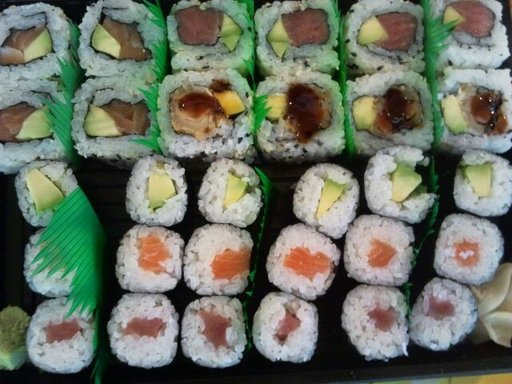

In [244]:
import random
from PIL import Image
random.seed(42)
# glob finds all pathnames matching a pattern
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_img_path = random.choice(image_path_list)
img_class = random_img_path.parent.stem

img = Image.open(random_img_path)
print(f"{img.height}")
print(f'{img.width}')
img

(-0.5, 511.5, 383.5, -0.5)

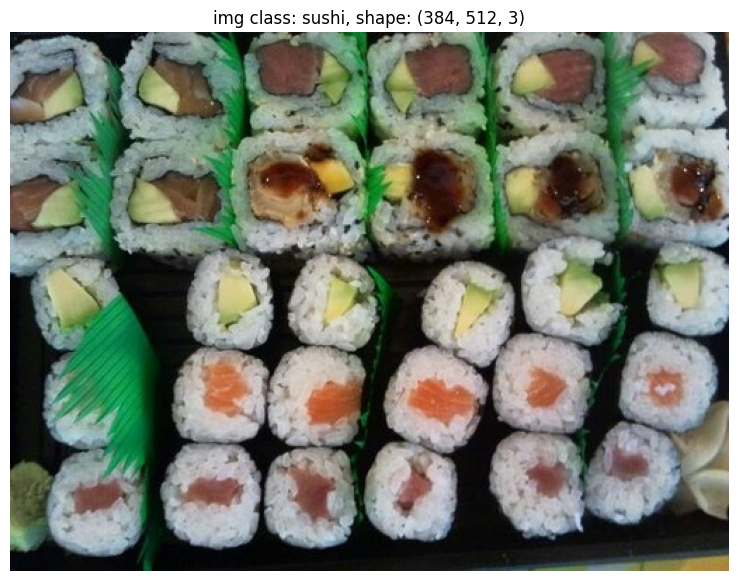

In [245]:
# image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt
# turn image into an array
img_as_arr = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_arr)
plt.title(f"img class: {img_class}, shape: {img_as_arr.shape}")
plt.axis(False)


In [246]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# turning image data into pytorch tensors
# then into a torch.utils.data.Dataset
# then into a torch.utils.data.DataLoader

# list of transforms to apply to the image
data_transforms = transforms.Compose([
    # matches TinyVGG architecture
    transforms.Resize(size=(64,64)),
    # half the imgs are flipped - increases training diversity
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn images into tensors
    transforms.ToTensor()
])
# pytorch is in the format color channels, width, height
data_transforms(img).shape

torch.Size([3, 64, 64])

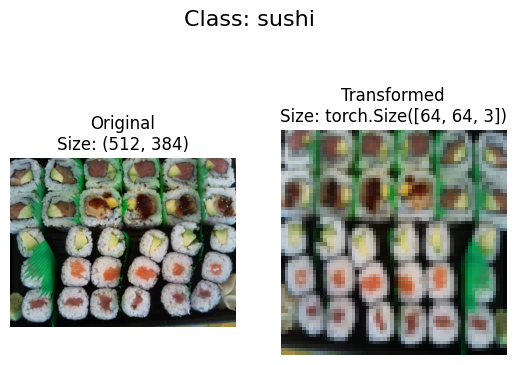

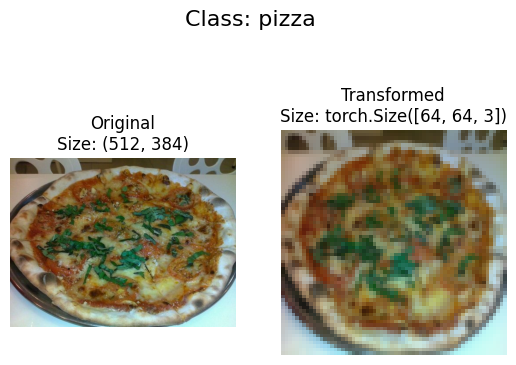

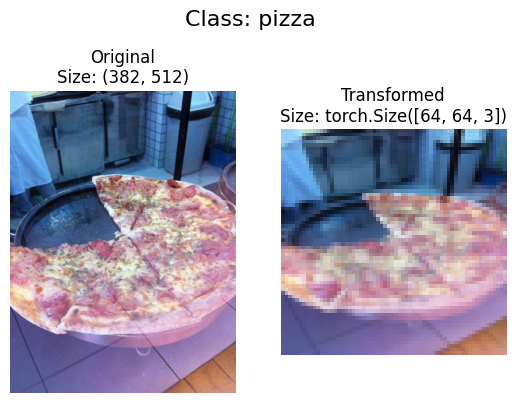

In [247]:
# plotting transformed images for further visualization
def plot_transformed_imgs(image_paths: list, transform, n=1, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as imgPtr:
            # first axis is original img
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(imgPtr)
            ax[0].set_title(f"Original\nSize: {imgPtr.size}")
            ax[0].axis(False)
            # second is transformed with dims switched for matplotlib
            transformed_image = transform(imgPtr).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
plot_transformed_imgs(image_path_list, 
                        data_transforms,
                       3,
                       42)
            

In [248]:
from torchvision import datasets

train_dir = image_path / "train"
test_dir = image_path / "test"

train_data = datasets.ImageFolder(train_dir,data_transforms)
test_data = datasets.ImageFolder(test_dir, data_transforms)
classes = train_data.classes


In [249]:
# visualizing data from the dataset
# important for troubleshoot the 3 big errors
# device, shape and type mismatch
img, label = train_data[0][0], train_data[0][1]
img.shape, img.dtype, type(label)

(torch.Size([3, 64, 64]), torch.float32, int)

Text(0.5, 1.0, 'pizza')

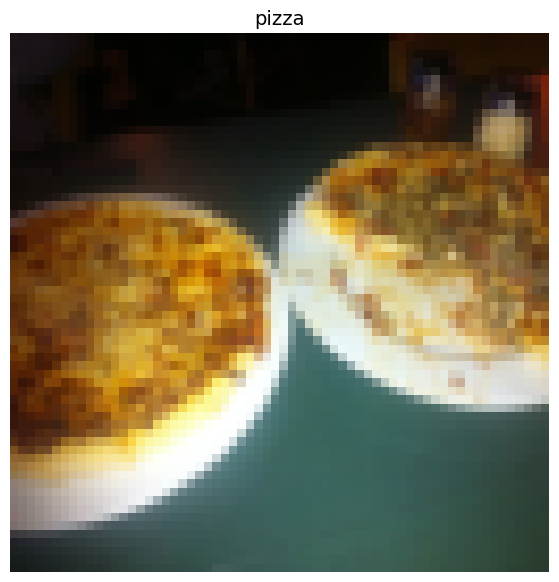

In [250]:
# visualizing with matplotlib from a dataset
# color channels last
img_permute = img.permute(1,2,0)
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(classes[label], fontsize=14)


In [251]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
# dataloader provides an iterable over a dataset basically
# specify parameter name when making a dataloader
dataLoader_Train = DataLoader(train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=True)
dataLoader_Test = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)
dataLoader_Train, dataLoader_Test

(<torch.utils.data.dataloader.DataLoader at 0x7ca3101eb9a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ca3101e9450>)

In [252]:
img, label = next((iter(dataLoader_Test)))
# dataloader adds a batch dimension
img.shape, label.shape


(torch.Size([1, 3, 64, 64]), torch.Size([1]))

In [253]:
# practice on using datasets without pre-built dataloaders
# should be able to load imgs, get classnames regularly and as a dict

import os
import pathlib
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [254]:
# replicatiing this functionality:
train_data.classes, train_data.class_to_idx
target_dir = train_dir

In [255]:
# retrieve classnames from the target directory
def retrieve_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"No classes in {directory}")
    else: 
        # return the classes, and a dictionary corresponding to their positions
        return classes, {name: i for i, name in enumerate(classes)}
retrieve_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [256]:
# creating a custom Dataset class
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    def __init__(self, target_dir: str, transform=None):
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = retrieve_classes(target_dir)
        
    def load_img(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_img(index)
        # expects path in format data_folder/class_name/jpg
        class_name = self.paths[index].parent.name
        class_index = self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img), class_index
        else:
            return img, class_index
        

In [257]:
# testing custom ImageFolder class
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

train_data_custom = ImageFolderCustom(target_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir, 
                                      transform=test_transforms)

train_data_custom.classes,
train_data_custom.classes == train_data.classes,
test_data_custom.classes == test_data.classes

True

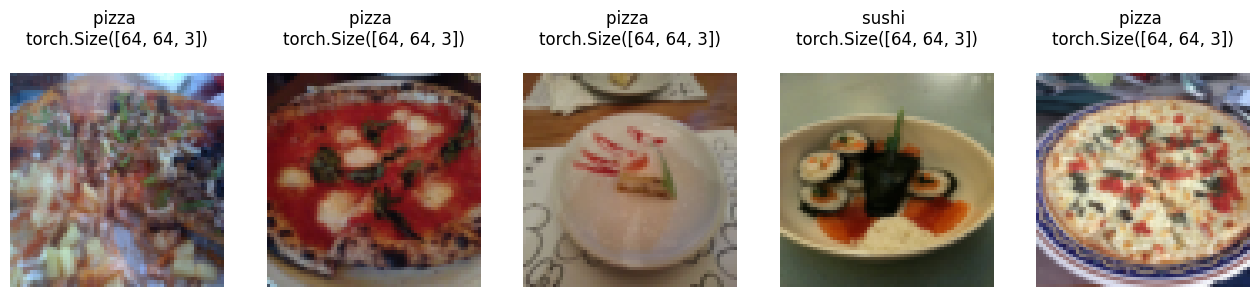

In [258]:
# more practice working with custom data visualization
def display_random_images(dSet: torch.utils.data.Dataset,
                         classes: List[str] = None,
                         image_num:int = 10,
                         display_shape:bool = True,
                         seed: int = None):
    if image_num > 10:
        image_num = 10
        display_shape = False
        print("Image num capped at 10, removing shape display.")
    if seed:
        random.seed(seed)
    plt.figure(figsize=(16,8))
    # randomly sample 10 indices from the dataset
    random_samples = random.sample(range(len(dSet)), k=image_num)
    for i, target_sample in enumerate(random_samples):
        # grab image tensor data and label from the dataset
        target_image, target_label = dSet[target_sample][0], dSet[target_sample][1]
        # set up image dims for matplotlib
        target_image_adjusted = target_image.permute(1,2,0)
        # plot each image
        plt.subplot(1, image_num, i + 1)
        plt.imshow(target_image_adjusted)
        plt.axis(False)
        if classes:
            title = f"{classes[target_label]}"
            if display_shape:
                title = title + " " + f"\n{target_image_adjusted.shape}\n"
        plt.title(title)

display_random_images(dSet=train_data,
                     classes=train_data.classes,
                     image_num=5,
                     seed=None)

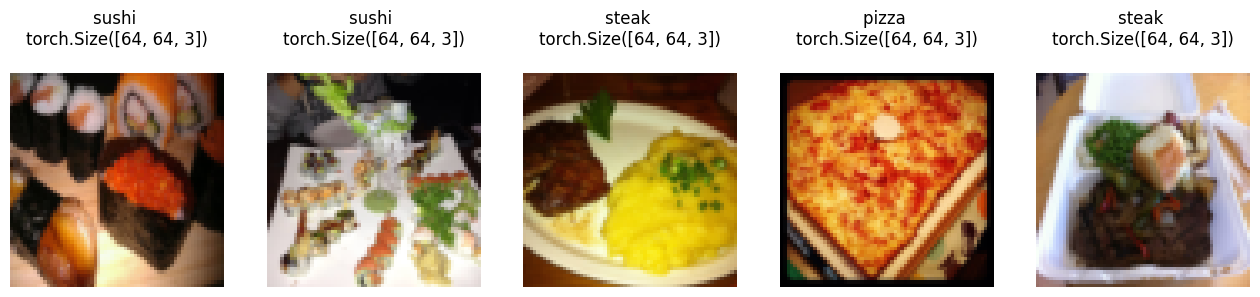

In [259]:
display_random_images(dSet=train_data_custom,
                     classes=train_data_custom.classes,
                     image_num=5,
                     )

In [260]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
train_dataLoaderCustom = DataLoader(dataset=train_data_custom,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS,
                                   shuffle=True)

test_dataLoaderCustom = DataLoader(dataset=test_data_custom,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS,
                                   shuffle=True)
train_dataLoaderCustom, test_dataLoaderCustom

(<torch.utils.data.dataloader.DataLoader at 0x7ca2cb37fe80>,
 <torch.utils.data.dataloader.DataLoader at 0x7ca2cb37fe50>)

In [261]:
train_dataLoaderCustom.dataset[0]

(tensor([[[0.9490, 0.8941, 0.9412,  ..., 0.0863, 0.0667, 0.0588],
          [0.8627, 0.7490, 0.8000,  ..., 0.1961, 0.1725, 0.1529],
          [0.7373, 0.6706, 0.6667,  ..., 0.0824, 0.0824, 0.0863],
          ...,
          [0.1843, 0.2000, 0.2078,  ..., 0.4392, 0.4471, 0.4314],
          [0.3216, 0.3098, 0.2706,  ..., 0.4235, 0.3647, 0.3255],
          [0.8118, 0.7922, 0.7608,  ..., 0.2745, 0.3137, 0.3765]],
 
         [[0.9608, 0.9412, 0.9608,  ..., 0.2078, 0.1804, 0.1490],
          [0.8745, 0.8510, 0.8824,  ..., 0.3569, 0.3373, 0.3176],
          [0.7608, 0.7843, 0.7882,  ..., 0.2000, 0.1961, 0.2000],
          ...,
          [0.2431, 0.2588, 0.2824,  ..., 0.4549, 0.4824, 0.4902],
          [0.4314, 0.4196, 0.3843,  ..., 0.4863, 0.4275, 0.4000],
          [0.8824, 0.8745, 0.8510,  ..., 0.3725, 0.4196, 0.4941]],
 
         [[0.7412, 0.7333, 0.7412,  ..., 0.3922, 0.3765, 0.3608],
          [0.7412, 0.7333, 0.7373,  ..., 0.4471, 0.4392, 0.4353],
          [0.7098, 0.7255, 0.7294,  ...,

In [262]:
img, label = next(iter(train_dataLoaderCustom))
img.shape, label.shape 

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [263]:
# Section on Data Augmentation(increase training data diversity)
# specifically working with TrivialAugment
train_augmentation_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    # param refers to intensity of transform
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

test_augmentation_transform = transforms.Compose([
    transforms.Resize(size=(224,224)), 
    transforms.ToTensor() 
])

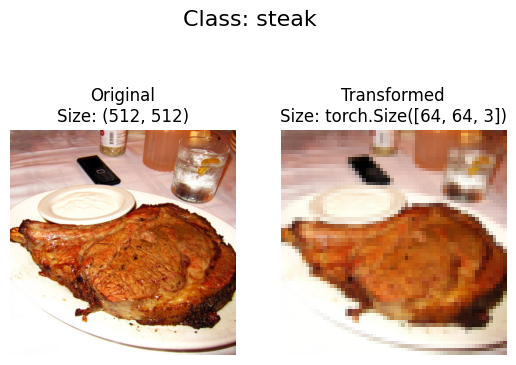

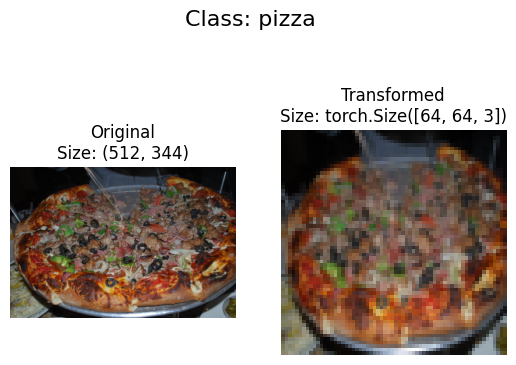

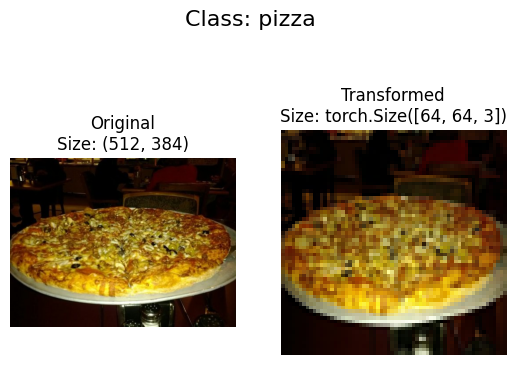

In [264]:
# making a new dataset with trivial augment
augmentDSet = datasets.ImageFolder(
    train_dir,
    transform=train_augmentation_transform)

# display_random_images(dSet=augmentDSet,
#                      classes=train_data_custom.classes,
#                      image_num=2)

plot_transformed_imgs(image_paths=image_path_list, 
                      transform=train_augmentation_transform, 
                      n=3, 
                      seed=None)
# pretty cool how such a strange change to images can drastically affect
# the accuracy of a model

In [265]:
# testing a computer vision model on the custom dataset

simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])
workers = os.cpu_count()
cvModelData_Train = datasets.ImageFolder(train_dir, simple_transform)
cvModelData_Test = datasets.ImageFolder(test_dir, simple_transform)
# dataloaders without trivial augment            
cvModelLoader_Train = DataLoader(dataset=cvModelData_Train,
                                   batch_size=32,
                                   num_workers=workers,
                                   shuffle=True)

cvModelLoader_Test = DataLoader(dataset=cvModelData_Test,
                                   batch_size=32,
                                   num_workers=workers)

# dataloader with trivial augment for later experiments
# we only need one that augments training data
trivialAugDataLoader = DataLoader(dataset=augmentDSet,
                       batch_size=32,
                       num_workers=workers,
                       shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [266]:
class CVModel(nn.Module):
    def __init__(self, inputs, hiddenUnits, output):
        super().__init__()
        self.blockOne = nn.Sequential(
            nn.Conv2d(
            in_channels=inputs,
            out_channels=hiddenUnits,
            kernel_size=3,
            stride=1,
            padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=hiddenUnits,
            out_channels=hiddenUnits,
            kernel_size=3,
            stride=1,
            padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
            stride=2)
        )
        self.blockTwo = nn.Sequential(
            nn.Conv2d(
            in_channels=hiddenUnits,
            out_channels=hiddenUnits,
            kernel_size=3,
            stride=1,
            padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=hiddenUnits,
            out_channels=hiddenUnits,
            kernel_size=3,
            stride=1,
            padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
            stride=2)
        )
        self.classifierLayer = nn.Sequential(
            nn.Flatten(),
            # find out what in_features is multiplied with by
            # using the output of a forward pass that outputs the shape
            nn.Linear(in_features=hiddenUnits*13*13,
            out_features=len(cvModelData_Train.classes))
        )

    def forward(self, input):
        return self.classifierLayer(self.blockTwo(self.blockOne(input)))



In [267]:
# input is always # of color channels
model_0 = CVModel(inputs=3,
                 hiddenUnits=8,
                 output=len(cvModelData_Train.classes)).to(device)

In [268]:
def calculateAccuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return (correct / len(y_pred)) * 100

In [269]:
# re-using code from CV notebook 
cvLoss = nn.CrossEntropyLoss()
cvOptimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)
def train_model(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0,0
  model.train()
  for batch, (train_image, label) in enumerate(data_loader):
    train_image, label = train_image.to(device), label.to(device)
    # create training predictions
    image_training_preds = model(train_image)
    # calculate loss and accuracy
    loss = loss_fn(image_training_preds, label)
    train_loss += loss.item()
    train_acc += accuracy_fn(label, image_training_preds.argmax(dim=1))
    # zero optimizer, backprop, update weights with optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # avg out training loss over all
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  return {
    "model_name": model.__class__.__name__,
    "train_loss": train_loss,
    "train_acc": train_acc
  }

In [270]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = None):
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for image, label in data_loader:
      image,label = image.to(device),label.to(device)
      model_preds = model(image)
      # accumulating loss/acc values per batch
      loss += loss_fn(model_preds, label)
      acc += accuracy_fn(label, model_preds.argmax(dim=1))
    # find avg loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)
    print({
        "model_name": model.__class__.__name__,
        "model_test_loss": loss.item(),
        "model_test_acc": acc
    })
    return {
        "model_name": model.__class__.__name__,
        "model_test_loss": loss.item(),
        "model_test_acc": acc
        }

In [271]:
import torchinfo
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
CVModel                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 8, 30, 30]            --
│    └─Conv2d: 2-1                       [1, 8, 62, 62]            224
│    └─ReLU: 2-2                         [1, 8, 62, 62]            --
│    └─Conv2d: 2-3                       [1, 8, 60, 60]            584
│    └─ReLU: 2-4                         [1, 8, 60, 60]            --
│    └─MaxPool2d: 2-5                    [1, 8, 30, 30]            --
├─Sequential: 1-2                        [1, 8, 13, 13]            --
│    └─Conv2d: 2-6                       [1, 8, 28, 28]            584
│    └─ReLU: 2-7                         [1, 8, 28, 28]            --
│    └─Conv2d: 2-8                       [1, 8, 26, 26]            584
│    └─ReLU: 2-9                         [1, 8, 26, 26]            --
│    └─MaxPool2d: 2-10                   [1, 8, 13, 13]            --
├─Sequentia

In [272]:
from timeit import default_timer as timer
def print_training_time(startTime:float,
                        endTime:float,
                        device:torch.device = None):
  runTime = endTime - startTime
  print(f"Training time for {device}:{runTime:.3f} seconds ")
  return runTime

In [273]:
from timeit import default_timer as timer
print("Model results without trivial augmentation.")
gpuTimeStart = timer()
epochs = 2
for epoch in range((epochs)):
  train_model(model_0,
              cvModelLoader_Train,
              cvLoss,
              cvOptimizer,
              calculateAccuracy,
              device)
  eval_model(model_0,
             cvModelLoader_Test,
             cvLoss,
             calculateAccuracy,
             device)
gpuTimeEnd = timer()
gpuTrainTime = print_training_time(gpuTimeStart,
                        gpuTimeEnd,
                        str(next(model_0.parameters()).device))


Model results without trivial augmentation.
{'model_name': 'CVModel', 'model_test_loss': 1.0637991428375244, 'model_test_acc': 54.166666666666664}
{'model_name': 'CVModel', 'model_test_loss': 1.052836298942566, 'model_test_acc': 54.166666666666664}
Training time for cuda:0:1.561 seconds 


In [274]:
# input is always # of color channels
model_1 = CVModel(inputs=3,
                 hiddenUnits=8,
                 output=len(cvModelData_Train.classes)).to(device)

In [275]:
# from the results below, data augmentation generally doesn't help in this case
# model performs better without it
from timeit import default_timer as timer
print("Model results with trivial augmentation.")
torch.manual_seed(42)
torch.cuda.manual_seed(42)
gpuTimeStart = timer()
epochs = 5
for epoch in range((epochs)):
  train_model(model_1,
              trivialAugDataLoader,
              cvLoss,
              cvOptimizer,
              calculateAccuracy,
              device)
  eval_model(model_1,
             cvModelLoader_Test,
             cvLoss,
             calculateAccuracy,
             device)
gpuTimeEnd = timer()
gpuTrainTime = print_training_time(gpuTimeStart,
                        gpuTimeEnd,
                        str(next(model_0.parameters()).device))

Model results with trivial augmentation.
{'model_name': 'CVModel', 'model_test_loss': 1.1007341146469116, 'model_test_acc': 19.791666666666668}
{'model_name': 'CVModel', 'model_test_loss': 1.1007341146469116, 'model_test_acc': 19.791666666666668}
{'model_name': 'CVModel', 'model_test_loss': 1.1007341146469116, 'model_test_acc': 19.791666666666668}
{'model_name': 'CVModel', 'model_test_loss': 1.1007341146469116, 'model_test_acc': 19.791666666666668}
{'model_name': 'CVModel', 'model_test_loss': 1.1007341146469116, 'model_test_acc': 19.791666666666668}
Training time for cuda:0:4.082 seconds 


In [276]:
# making a prediction on a custom image taken from github
import requests
custom_img_path = data_path / "04-pizza-dad.jpeg"
if not custom_img_path.is_file():
    with open(custom_img_path, "wb") as filePtr:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/04-pizza-dad.jpeg")
        filePtr.write(request.content)
else:
    print("Already have image stored.")
    


Already have image stored.


In [295]:
import torchvision
custom_image_uint8 = torchvision.io.read_image(str(custom_img_path))
# for this to work: img dtype of torch.float32. /255 puts imgs between 0 and 1
custom_img_float32 = custom_image_uint8.type(torch.float32) / 255
# shape 3,64,64, # right device
transform = torchvision.transforms.Resize((64,64))
custom_img = transform(custom_img_float32).to(device)

model_1.eval()
with torch.inference_mode():
    # have to add a batch dimension
    pred = model_1(custom_img.unsqueeze(0))
# printing the predicted class    
probs = torch.softmax(pred, dim=1)
# model isn't performing too well, usually probability is stacked on one class
probs

tensor([[0.3317, 0.3365, 0.3318]], device='cuda:0')